### Importing the Libraries

In [5]:
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Embedding
from keras.preprocessing import sequence
from keras.layers import LSTM
from keras import models, layers
from keras_visualizer import visualizer
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score
from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score
from imblearn.metrics import specificity_score
import matplotlib.pyplot as plt
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

TOP_WORDS = 8000
MAX_WORDS = 500

### Loading the Dataset, applying Padding and Splitting the data

In [6]:
# load the dataset but only keep the top n words, zero the rest
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=TOP_WORDS)

# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(X_train, maxlen=MAX_WORDS)
X_test = sequence.pad_sequences(X_test, maxlen=MAX_WORDS)

X = numpy.concatenate((X_train, X_test), axis=0)
y = numpy.concatenate((y_train, y_test), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # split into train and test sets.

### Defining the Model Architecture

In [7]:
model = Sequential()
model.add(Embedding(TOP_WORDS, 100, input_length=MAX_WORDS))
model.add(LSTM(100,return_sequences=True))
model.add(Conv1D(64, 3, padding='same',activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.8))
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 100)          800000    
                                                                 
 lstm (LSTM)                 (None, 500, 100)          80400     
                                                                 
 conv1d (Conv1D)             (None, 500, 64)           19264     
                                                                 
 max_pooling1d (MaxPooling1  (None, 250, 64)           0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 16000)             0         
                                                                 
 dropout (Dropout)           (None, 16000)             0         
                                                        

In [8]:
visualizer(model, file_name="lstm_cnn", file_format="png", view=True)

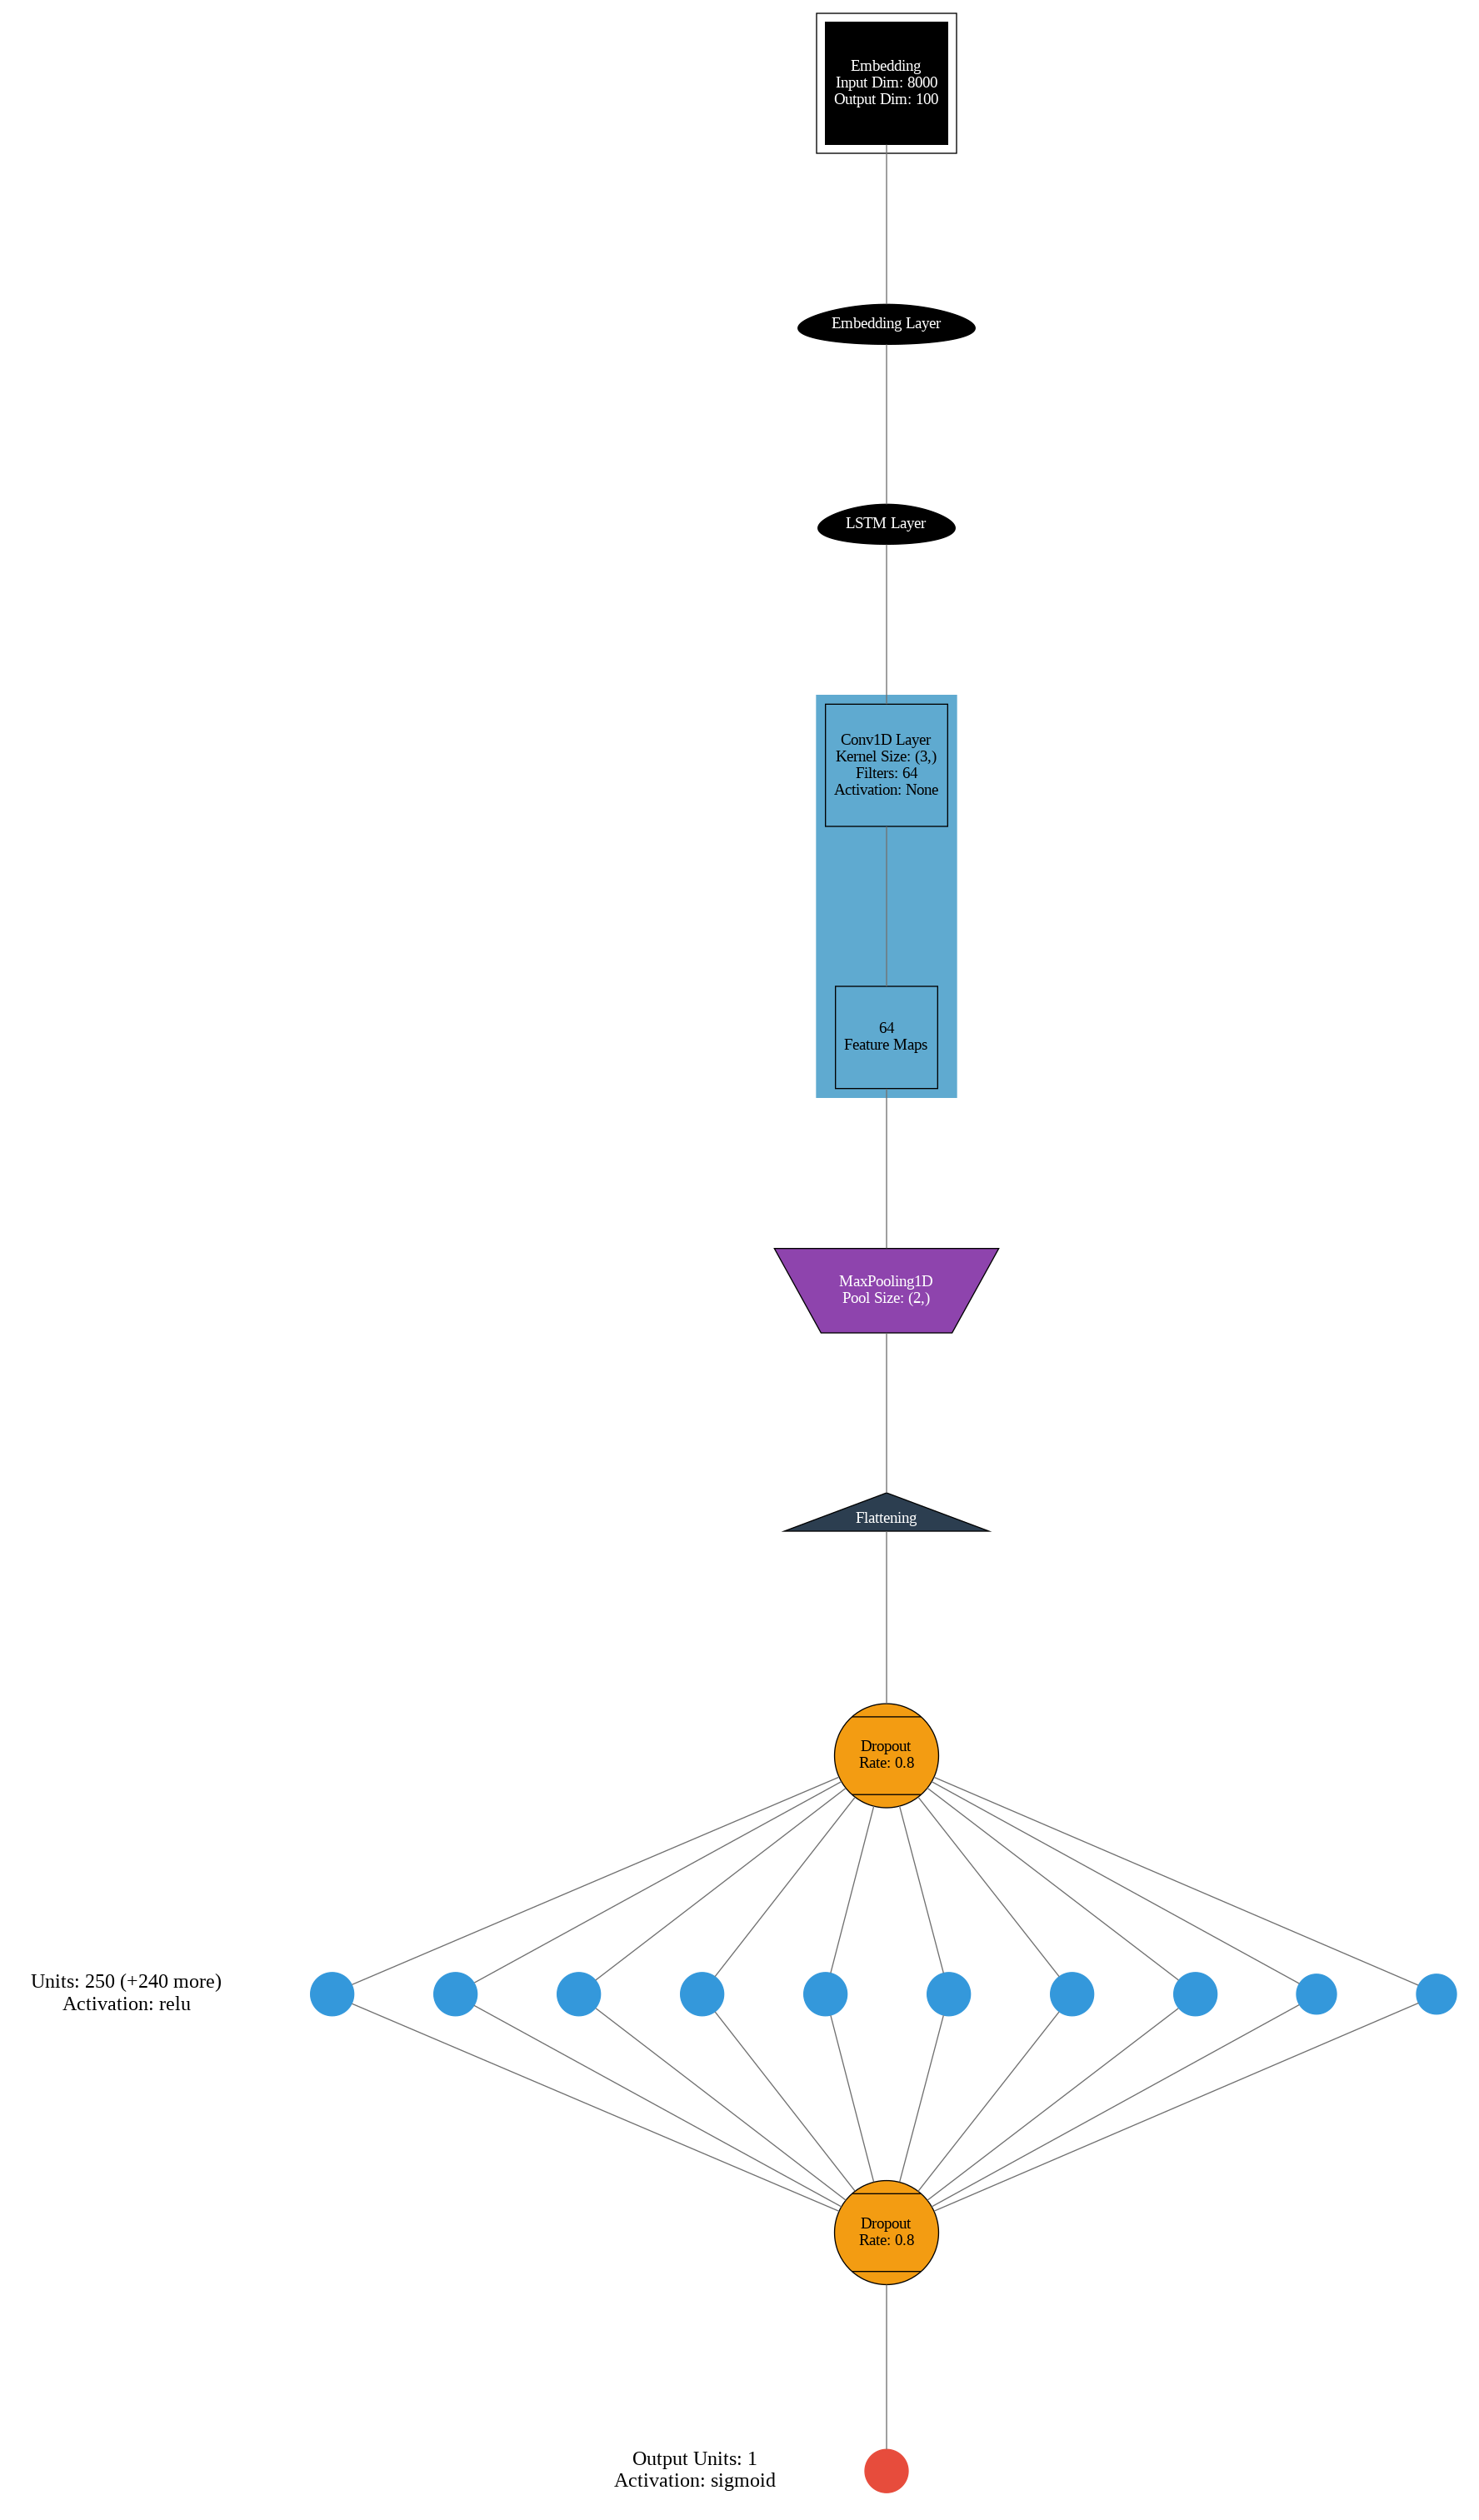

In [9]:
img = Image.open("lstm_cnn.png")
display(img)

### Training the Model


In [10]:
# fit the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=3, batch_size=128, verbose=2)

# final evaluation of the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

Epoch 1/3
219/219 - 472s - loss: 0.4187 - accuracy: 0.7877 - val_loss: 0.2654 - val_accuracy: 0.8897 - 472s/epoch - 2s/step
Epoch 2/3
219/219 - 443s - loss: 0.2140 - accuracy: 0.9175 - val_loss: 0.2982 - val_accuracy: 0.8844 - 443s/epoch - 2s/step
Epoch 3/3
219/219 - 444s - loss: 0.1665 - accuracy: 0.9373 - val_loss: 0.2724 - val_accuracy: 0.8907 - 444s/epoch - 2s/step
469/469 [==============================] - 72s 154ms/step - loss: 0.2539 - accuracy: 0.8962
Test loss: 0.25393351912498474
Test accuracy: 0.8962000012397766


### Evaluating the Model

In [11]:
pred = model.predict(X_test)
pred = [1 if x > 0.5 else 0 for x in pred]

469/469 [==============================] - 75s 157ms/step


##### Classification Report

In [12]:
print('Classification Report:')
print(classification_report(y_test, pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      7398
           1       0.89      0.91      0.90      7602

    accuracy                           0.90     15000
   macro avg       0.90      0.90      0.90     15000
weighted avg       0.90      0.90      0.90     15000



##### Confusion Matrix

In [13]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, pred))

Confusion Matrix:
[[6515  883]
 [ 674 6928]]


##### Evaluation Metrics

In [14]:
precision = precision_score(y_test, pred)
recall = recall_score(y_test, pred)
f1 = f1_score(y_test, pred)
specificity = specificity_score(y_test, pred)
accuracy = accuracy_score(y_test, pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Specificity: {specificity}')
print(f'Accuracy: {accuracy}')

Precision: 0.8869542952246832
Recall: 0.9113391212838726
F1 Score: 0.8989813793550898
Specificity: 0.8806434171397675
Accuracy: 0.8962


##### ROC Curve

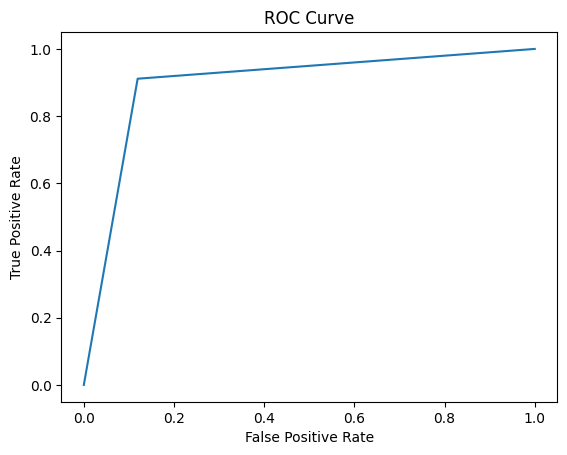

In [15]:
fpr, tpr, thresholds = roc_curve(y_test, pred)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

### Saving the Model

In [19]:
model.save("lstm_cnn_model.h5")